##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DeepDream

In [2]:
import tensorflow as tf

In [3]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

## Choose an image to dream-ify

For this tutorial, let's use an image of a [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg).

In [4]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

In [5]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
img = original_img

## Prepare the feature extraction model

Download and prepare a pre-trained image classification model. You will use [InceptionV3](https://keras.io/api/applications/inceptionv3/) which is similar to the model originally used in DeepDream. Note that any [pre-trained model](https://keras.io/api/applications/#available-models) will work, although you will have to adjust the layer names below if you change this.

In [6]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [7]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
# names = ['conv2d_8', 'mixed1', 'mixed2']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [8]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## Gradient ascent

Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image. 

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

The method that does this, below, is wrapped in a `tf.function` for performance. It uses an `input_signature` to ensure that the function is not retraced for different image sizes or `steps`/`step_size` values. See the [Concrete functions guide](../../guide/function.ipynb) for details.

In [9]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [10]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

In [11]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [12]:
get_tiled_gradients = TiledGradients(dream_model)

In [13]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

In [14]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

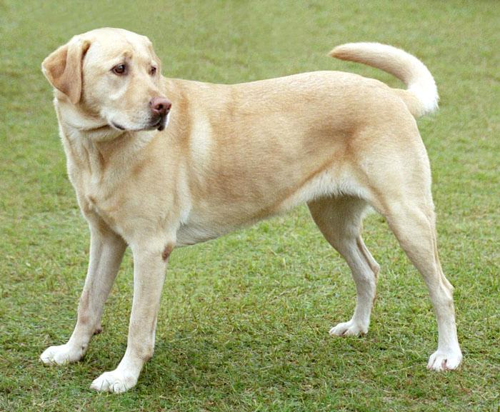

In [15]:
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [16]:
!mkdir frames
frame = img
frame_i = 0
PIL.Image.fromarray(np.uint8(frame)).save('frames/%04d.jpg'%frame_i)

A subdirectory or file frames already exists.


In [17]:
print(frame.shape)

(412, 500, 3)


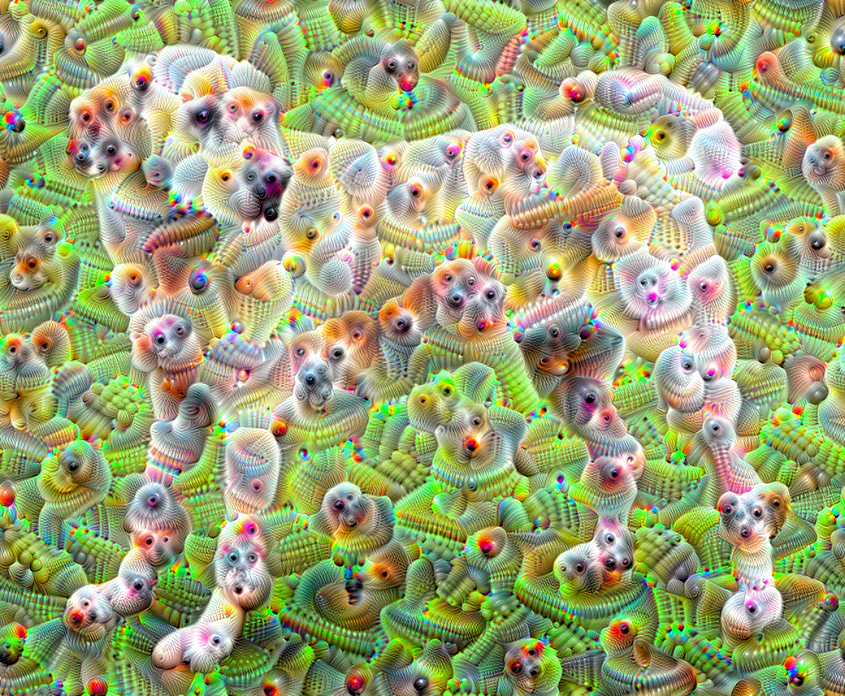

Octave 2, Step 90


In [18]:
input_img = PIL.Image.open('frames/%04d.jpg'%frame_i)
input_img = np.array(input_img)
img = run_deep_dream_with_octaves(img=input_img, step_size=0.01)

In [19]:
# Maximize the activations of these layers
names = ['conv2d_8', 'mixed2']
names = ['mixed9', 'conv2d_89', 'conv2d_91', 'conv2d_93']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
deepdream = DeepDream(dream_model)
get_tiled_gradients = TiledGradients(dream_model)

In [20]:
# input_img = PIL.Image.open('frames/%04d.jpg'%frame_i)
# input_img = np.array(input_img)
# img = run_deep_dream_with_octaves(img=input_img, step_size=0.01, octave_scale=2.5)
# frame = img
# frame_i += 1
# PIL.Image.fromarray(np.uint8(frame)).save('frames/%04d.jpg'%frame_i)

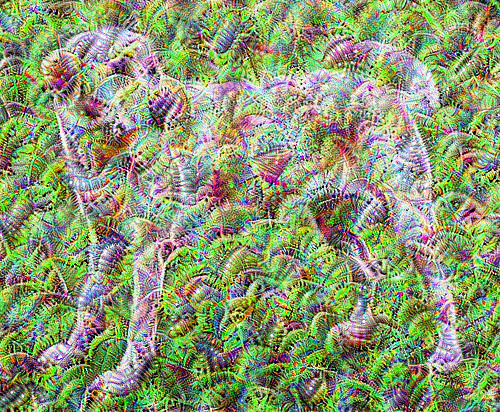

Octave 2, Step 90


In [21]:
# Maximize the activations of these layers
names_of_layers = [['conv2d_8', 'mixed1', 'mixed2'],['conv2d_35', 'mixed4', 'mixed5'],['conv2d_51', 'mixed7', 'mixed8']]
for names in names_of_layers:
    layers = [base_model.get_layer(name).output for name in names]
    
    # Create the feature extraction model
    dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
    deepdream = DeepDream(dream_model)
    get_tiled_gradients = TiledGradients(dream_model)
    
    input_img = PIL.Image.open('frames/%04d.jpg'%frame_i)
    input_img = np.array(input_img)
    img = run_deep_dream_with_octaves(img=input_img, step_size=0.01, octave_scale=1)
    frame = img
    frame_i += 1
    PIL.Image.fromarray(np.uint8(frame)).save('frames/%04d.jpg'%frame_i)

In [25]:
input_img = PIL.Image.open('sky1024px.jpg')
input_img = np.array(input_img)
frame = input_img
frame_i = 0
PIL.Image.fromarray(np.uint8(frame)).save('frames/sky1024px%04d.jpg'%frame_i)

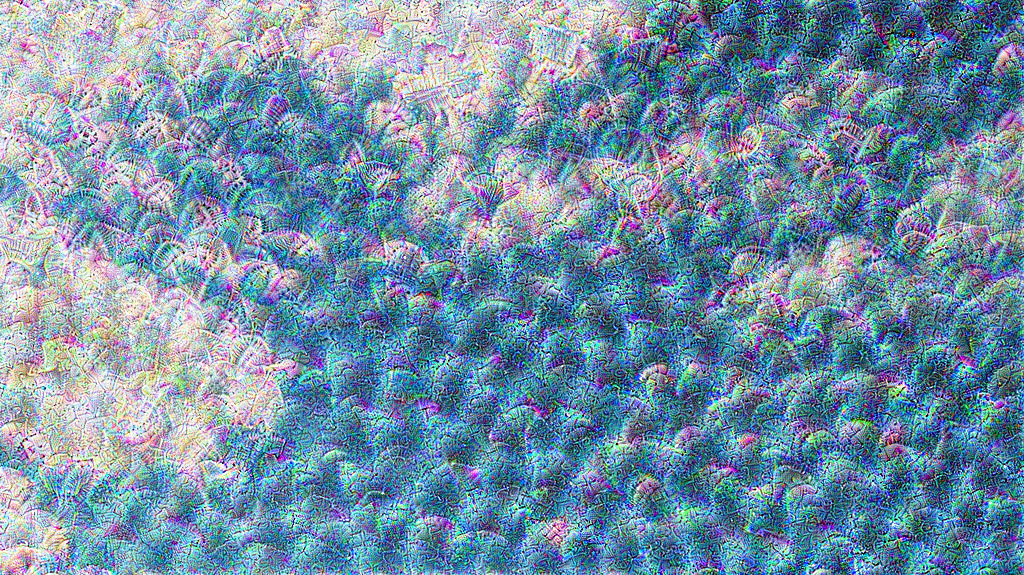

Octave 2, Step 90


In [26]:
# Maximize the activations of these layers
names_of_layers = [['conv2d_8', 'mixed1', 'mixed2'],['conv2d_35', 'mixed4', 'mixed5'],['conv2d_51', 'mixed7', 'mixed8']]
for names in names_of_layers:
    layers = [base_model.get_layer(name).output for name in names]
    
    # Create the feature extraction model
    dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
    deepdream = DeepDream(dream_model)
    get_tiled_gradients = TiledGradients(dream_model)
    
    input_img = PIL.Image.open('frames/sky1024px%04d.jpg'%frame_i)
    input_img = np.array(input_img)
    img = run_deep_dream_with_octaves(img=input_img, step_size=0.01, octave_scale=1)
    frame = img
    frame_i += 1
    PIL.Image.fromarray(np.uint8(frame)).save('frames/sky1024px%04d.jpg'%frame_i)